# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# Only basic libraries here
import numpy as np
import pandas as pd

In [85]:
df_base = pd.read_csv('/content/drive/My Drive/data.csv')

In [86]:
# obtain basic data info
display(df_base.info()) # basic info about entries including number of non-null values
display(df_base.nunique()) # basic info about entries including number of non-null values

(595212, 58)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

None

y                   2
xind_01             8
xind_02_cat         5
xind_03            12
xind_04_cat         3
xind_05_cat         8
xind_06_bin         2
xind_07_bin         2
xind_08_bin         2
xind_09_bin         2
xind_10_bin         2
xind_11_bin         2
xind_12_bin         2
xind_13_bin         2
xind_14             5
xind_15            14
xind_16_bin         2
xind_17_bin         2
xind_18_bin         2
xreg_01            10
xreg_02            19
xreg_03          5013
xcar_01_cat        13
xcar_02_cat         3
xcar_03_cat         3
xcar_04_cat        10
xcar_05_cat         3
xcar_06_cat        18
xcar_07_cat         3
xcar_08_cat         2
xcar_09_cat         6
xcar_10_cat         3
xcar_11_cat       104
xcar_11             5
xcar_12           184
xcar_13         70482
xcar_14           850
xcar_15            15
xcalc_01           10
xcalc_02           10
xcalc_03           10
xcalc_04            6
xcalc_05            7
xcalc_06           11
xcalc_07           10
xcalc_08  

In [87]:
#priprava dat
df = df_base.copy()

for col in df.columns:
  if '_bin' in col:
    df[col] = df[col].astype('bool')
  elif '_cat' in col:
    categories = pd.api.types.CategoricalDtype(categories=df[col].unique(), ordered=False)
    df[col] = df[col].astype(categories)

In [88]:
df.describe()

,y,xind_01,xind_03,xind_14,xind_15,xreg_01,xreg_02,xreg_03,xcar_11,xcar_12,xcar_13,xcar_14,xcar_15,xcalc_01,xcalc_02,xcalc_03,xcalc_04,xcalc_05,xcalc_06,xcalc_07,xcalc_08,xcalc_09,xcalc_10,xcalc_11,xcalc_12,xcalc_13,xcalc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,4.423318,0.012451,7.299922,0.610991,0.439184,0.551102,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.187401,1.983789,2.699902,0.127545,3.546042,0.287643,0.404264,0.793506,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,5.000000,0.400000,0.200000,0.525000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.000000,1.000000,4.000000,0.000000,7.000000,0.700000,0.300000,0.720677,3.000000,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.000000,3.000000,6.000000,0.000000,10.000000,0.900000,0.600000,1.000000,3.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,1.000000,7.000000,11.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


#2:

In [89]:
#binning - připravené funkce pro použití na sloupce
def eq_width(col, bins = 100):
  #samostatne pracuju s hodnotami a nan
  values = col.loc[col >= 0].copy()
  nvalues = col.loc[col < 0].copy()
  values = pd.cut(values, bins, labels=range(bins))
  if nvalues.shape[0] != 0:
    nvalues = pd.cut(nvalues, 1, labels={values.astype('Int64').mean().astype(int)}) #pro neznamou hodnotu pouziju prumernou
  sol = pd.concat([values, nvalues], axis=0).sort_index().astype('Int64')
  return sol

def eq_depth(col, bins = 100):
  #samostatne pracuju s hodnotami a nan, takze je mozne ze nan bude mit vetsi hloubku
  values = col.loc[col >= 0].copy()
  nvalues = col.loc[col < 0].copy()
  values = pd.qcut(values, bins, labels=range(bins))
  if nvalues.shape[0] != 0:
    nvalues = pd.qcut(nvalues, 1, labels={values.astype('Int64').mean().astype(int)}) #pro neznamou hodnotu pouziju prumernou
  sol = pd.concat([values, nvalues], axis=0).sort_index().astype('Int64')
  return sol
  

count    595212.000000
mean         49.495081
std          28.867229
min           0.000000
25%          24.000000
50%          49.000000
75%          74.250000
max          99.000000
Name: xcar_13, dtype: float64


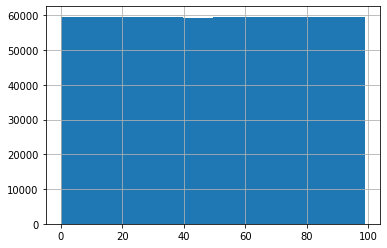

In [91]:
df_bins_ed = df.copy() #budu používat kopii dat pro další jejich úpravy

#equal depth pro sloupce 'xcar_13', 'xreg_03' a 'xcar_14'
df_bins_ed['xcar_13'] = eq_depth(df_bins_ed['xcar_13'])
print(df_bins_ed['xcar_13'].describe())
df_bins_ed.xcar_13.hist() #je videt ze hodnoty jsou rovnomerne rozdelene

df_bins_ed['xreg_03'] = eq_depth(df_bins_ed['xreg_03'])

df_bins_ed['xcar_14'] = eq_depth(df_bins_ed['xcar_14'], 20)

count    595212.000000
mean         15.716682
std           6.480549
min           0.000000
25%          12.000000
50%          14.000000
75%          18.000000
max          99.000000
Name: xcar_13, dtype: float64


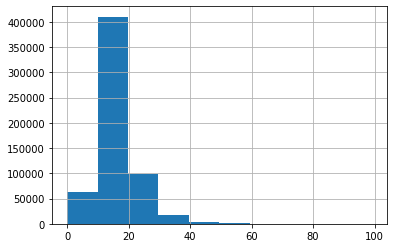

In [92]:
df_bins_ew = df.copy()
#equal width pro sloupce 'xcar_13', 'xreg_03' a 'xcar_14'

#equal width pro sloupec 'xcar_13'
df_bins_ew['xcar_13'] = eq_width(df_bins_ew['xcar_13'])
print(df_bins_ew['xcar_13'].describe())
df_bins_ew.xcar_13.hist() #je videt ze hodnoty nejsou rovnomerne rozdelene

count    595212.000000
mean         20.362377
std           7.865870
min           0.000000
25%          15.000000
50%          20.000000
75%          23.000000
max          99.000000
Name: xreg_03, dtype: float64


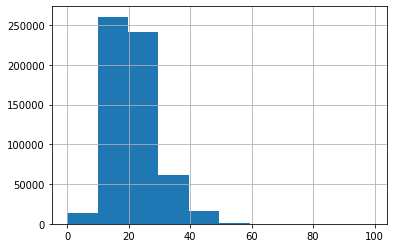

In [93]:
#equal width pro sloupec 'xreg_03'
df_bins_ew['xreg_03'] = eq_width(df_bins_ew['xreg_03'])
print(df_bins_ew['xreg_03'].describe())
df_bins_ew.xreg_03.hist() #je videt ze hodnoty nejsou rovnomerne rozdelene

count    595212.000000
mean         49.753936
std           8.330646
min           0.000000
25%          46.000000
50%          49.000000
75%          54.000000
max          99.000000
Name: xcar_14, dtype: float64


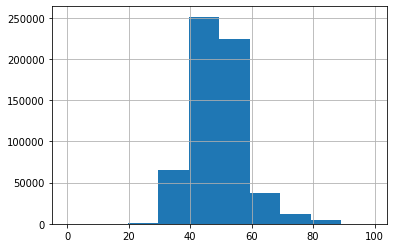

In [94]:
#equal width pro sloupec 'xcar_14'
df_bins_ew['xcar_14'] = eq_width(df_bins_ew['xcar_14'])
print(df_bins_ew['xcar_14'].describe())
df_bins_ew.xcar_14.hist() #je videt ze hodnoty nejsou rovnomerne rozdelene,
#  ale podle stredni hodnoty je alespon blize nez predchozi prevedeny sloupec

In [95]:
#funkce pro klasifikaci
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
def classify_base(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
  return classify_split(X_train, y_train, X_test, y_test)

def classify_w_clf(X,y,clf):
  X,Xt,y,yt = train_test_split(X, y, test_size=.4, random_state=42)
  return classify_full(X,y,Xt,yt,clf)

def classify_split(X,y,Xt,yt):
  clf = RandomForestClassifier(max_depth=5, n_estimators=50, max_features=1)
  #clf = AdaBoostClassifier()
  return classify_full(X,y,Xt,yt, clf)

def classify_full(X,y,Xt,yt, clf):
  clf.fit(X, y)
  display(clf.score(Xt, yt))
  y_pred = clf.predict(Xt)
  return confusion_matrix(yt, y_pred)

In [96]:
#priprava klasifikatoru
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB()]
names = ["Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes"]

In [97]:
#klasifikace dosavadnich uprav
print('TN      FP\nFN      TP\n')
for name, clf in zip(names, classifiers):
  display(name)

  print('data puvodni:')
  y = df_base['y']
  X = df_base.drop(['y'],axis=1)
  display(classify_w_clf(X,y,clf))

  print('data po upravach:')
  y = df['y']
  X = df.drop(['y'],axis=1)
  display(classify_w_clf(X,y,clf))

  print('data s equal width:')
  y = df_bins_ew['y']
  X = df_bins_ew.drop(['y'],axis=1)
  display(classify_w_clf(X,y,clf))

  print('data s equal depth:')
  y = df_bins_ed['y']
  X = df_bins_ed.drop(['y'],axis=1)
  display(classify_w_clf(X,y,clf))

#vestinou klasifikuje jako 0 pro vsechny verze, binning nektere vysledky 
#pozmeni, ale ne vyznamne

#k-Nearest Neighbors
#data puvodni:
#0.9596320641787597
#array([[228420,    904],
#       [  8707,     54]])
#data po upravach:
#0.9596320641787597
#array([[228420,    904],
#       [  8707,     54]])
#data a binning:
#0.9599512779049499
#array([[228495,    829],
#       [  8706,     55]])

TN      FP
FN      TP



'Decision Tree'

data puvodni:


0.9631518155280677

array([[229309,     15],
       [  8758,      3]])

data po upravach:


0.9631602158892832

array([[229313,     11],
       [  8760,      1]])

data s equal width:


0.9631938173341453

array([[229319,      5],
       [  8758,      3]])

data s equal depth:


0.9631938173341453

array([[229321,      3],
       [  8760,      1]])

'Random Forest'

data puvodni:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data po upravach:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data s equal width:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data s equal depth:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'AdaBoost'

data puvodni:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data po upravach:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data s equal width:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

data s equal depth:


0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Naive Bayes'

data puvodni:


0.9067013881596908

array([[214801,  14523],
       [  7690,   1071]])

data po upravach:


0.9067013881596908

array([[214801,  14523],
       [  7690,   1071]])

data s equal width:


0.9010857466871075

array([[213368,  15956],
       [  7594,   1167]])

data s equal depth:


0.9108805678644182

array([[215863,  13461],
       [  7757,   1004]])

#3:

In [98]:
#3. balance - oversampling a undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

In [99]:
#nahodny undersampling
y = df_bins_ew['y']
X = df_bins_ew.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
display('Pocet prvku po undersamplingu: ' + str(X_res.shape[0]))

for name, clf in zip(names, classifiers):
  display(name)
  display(classify_full(X_res, y_res, X_test, y_test,clf)) #celkove skore se zhorsilo, ale pocet
#true positive se vyrazne zvysil, ještě výrazněji se ale zvětšil false negative. Ze všech testovaných
#sad příznaků má jejich množství nejvyšší.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Pocet prvku po undersamplingu: 25866'

'Decision Tree'

0.7232122981288195

array([[168551,  60773],
       [  5126,   3635]])

'Random Forest'

0.5964676481088687

array([[137200,  92124],
       [  3951,   4810]])

'AdaBoost'

0.6152676565092299

array([[141537,  87787],
       [  3812,   4949]])

'Naive Bayes'

0.7276098872251506

array([[169653,  59671],
       [  5181,   3580]])

In [100]:
#TomekLinks
tl = TomekLinks(random_state=42)
X_res, y_res = tl.fit_resample(X_train, y_train)
display('Pocet prvku po undersamplingu: ' + str(X_res.shape[0]))

for name, clf in zip(names, classifiers):
  display(name)
  display(classify_full(X_res, y_res, X_test, y_test,clf)) 
#výkon je srovnatelný s daty před samplingem, pořád není moc pokusů o volbu positive.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Pocet prvku po undersamplingu: 352986'

'Decision Tree'

0.9632022176953609

array([[229322,      2],
       [  8759,      2]])

'Random Forest'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'AdaBoost'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Naive Bayes'

0.8997248881701914

array([[213026,  16298],
       [  7576,   1185]])

In [101]:
#oversampling SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
display('Pocet prvku po undersamplingu: ' + str(X_res.shape[0]))

for name, clf in zip(names, classifiers):
  display(name)
  display(classify_full(X_res, y_res, X_test, y_test,clf))
#stejně jako u ostatních, se zvyšujícím se true positive se zvyšuje i false negative, a to přibližně 20x rychleji.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Pocet prvku po undersamplingu: 688388'

'Decision Tree'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Random Forest'

0.8142848142470126

array([[191948,  37376],
       [  6840,   1921]])

'AdaBoost'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Naive Bayes'

0.673150345464855

array([[156515,  72809],
       [  5009,   3752]])

In [102]:
#kombinace SMOTE a Tomek
from imblearn.combine import SMOTETomek
st = SMOTETomek(random_state=42)
X_res, y_res = st.fit_resample(X_train, y_train)
display('Pocet prvku po undersamplingu: ' + str(X_res.shape[0]))

for name, clf in zip(names, classifiers):
  display(name)
  display(classify_full(X_res, y_res, X_test, y_test,clf))
  #Ani tento pomalý algoritmus se nedokázal vymanit z rychlého růstu false negative s růstem true positive.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Pocet prvku po undersamplingu: 688386'

'Decision Tree'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Random Forest'

0.7816074091185921

array([[183822,  45502],
       [  6494,   2267]])

'AdaBoost'

0.9632022176953609

array([[229324,      0],
       [  8761,      0]])

'Naive Bayes'

0.673150345464855

array([[156515,  72809],
       [  5009,   3752]])

#4:
Závěr: prediktory na původních datech a datech bez samplingu víceméně vše predikovaly jako false. Proto se nedá říct jestli je binning podle šířky nebo hloubky úspěšnější, oba mají podobné výsledky, a to i nezávisle na tom, jestli interpretujeme výsledky jako čísla nebo kategoricky. Klasifikátory začaly volit true až po využití samplingu. S tím se ale také hned objevilo mnoho false negative označení, které významně převyšují true positive. Jen v několika případech se podařilo správně označit většinu positive záznamů, ale za cenu okolo 90000 false negative označení. Z klasifikátorů nejvíce jako true označovaly KNN a naivní bayes, KNN jsem nakonec ale z klasifikátorů odebral, protože jeho průběh byl pomalý. Nejpřesnějšími tedy zůstaly klasifikátory označující vše jako false, a to asi kvůli zmiňovanému rychlému růstu false negative.